In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


# Load the data

In [2]:
import pandas as pd
from datetime import datetime

In [62]:
import csv
with open('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv') as f:
    docs = list(csv.DictReader(f))

## Reformat it so is pandas friendly

In [63]:
new_docs = []
for doc in docs:
    meta = {k: doc[k] for k in ['Province/State', 'Country/Region', 'Lat', 'Long']}
    for k, v in doc.items():
        if k in meta: continue
        new_doc = meta.copy()
        new_doc['date'] = datetime.strptime(k, '%m/%d/%y')
        new_doc['cnt'] = int(v)
        new_docs.append(new_doc)
        

In [64]:
df = (
    pd.DataFrame(new_docs)
      .rename(
          columns={
              'Province/State': 'province',
              'Country/Region': 'country',
              'Lat': 'lat', 'Long': 'long'
          }
      )
)

In [98]:
def get_rate(df, min_cnt=100, rolling_win=7):
    s = df.groupby('date').cnt.sum().sort_index().rolling(rolling_win).mean()
    s = s[s >= min_cnt]
    return s / s.shift(1) 

def plot_rate(fig, rate, name, line=None, opacity=None):
    fig.add_trace(
        go.Scatter(
            x=rate.index,
            y=rate.values,
            name=name,
            line=line,
            opacity=opacity
        )
    )

# Start plotting

## Current status

<IPython.core.display.Javascript object>


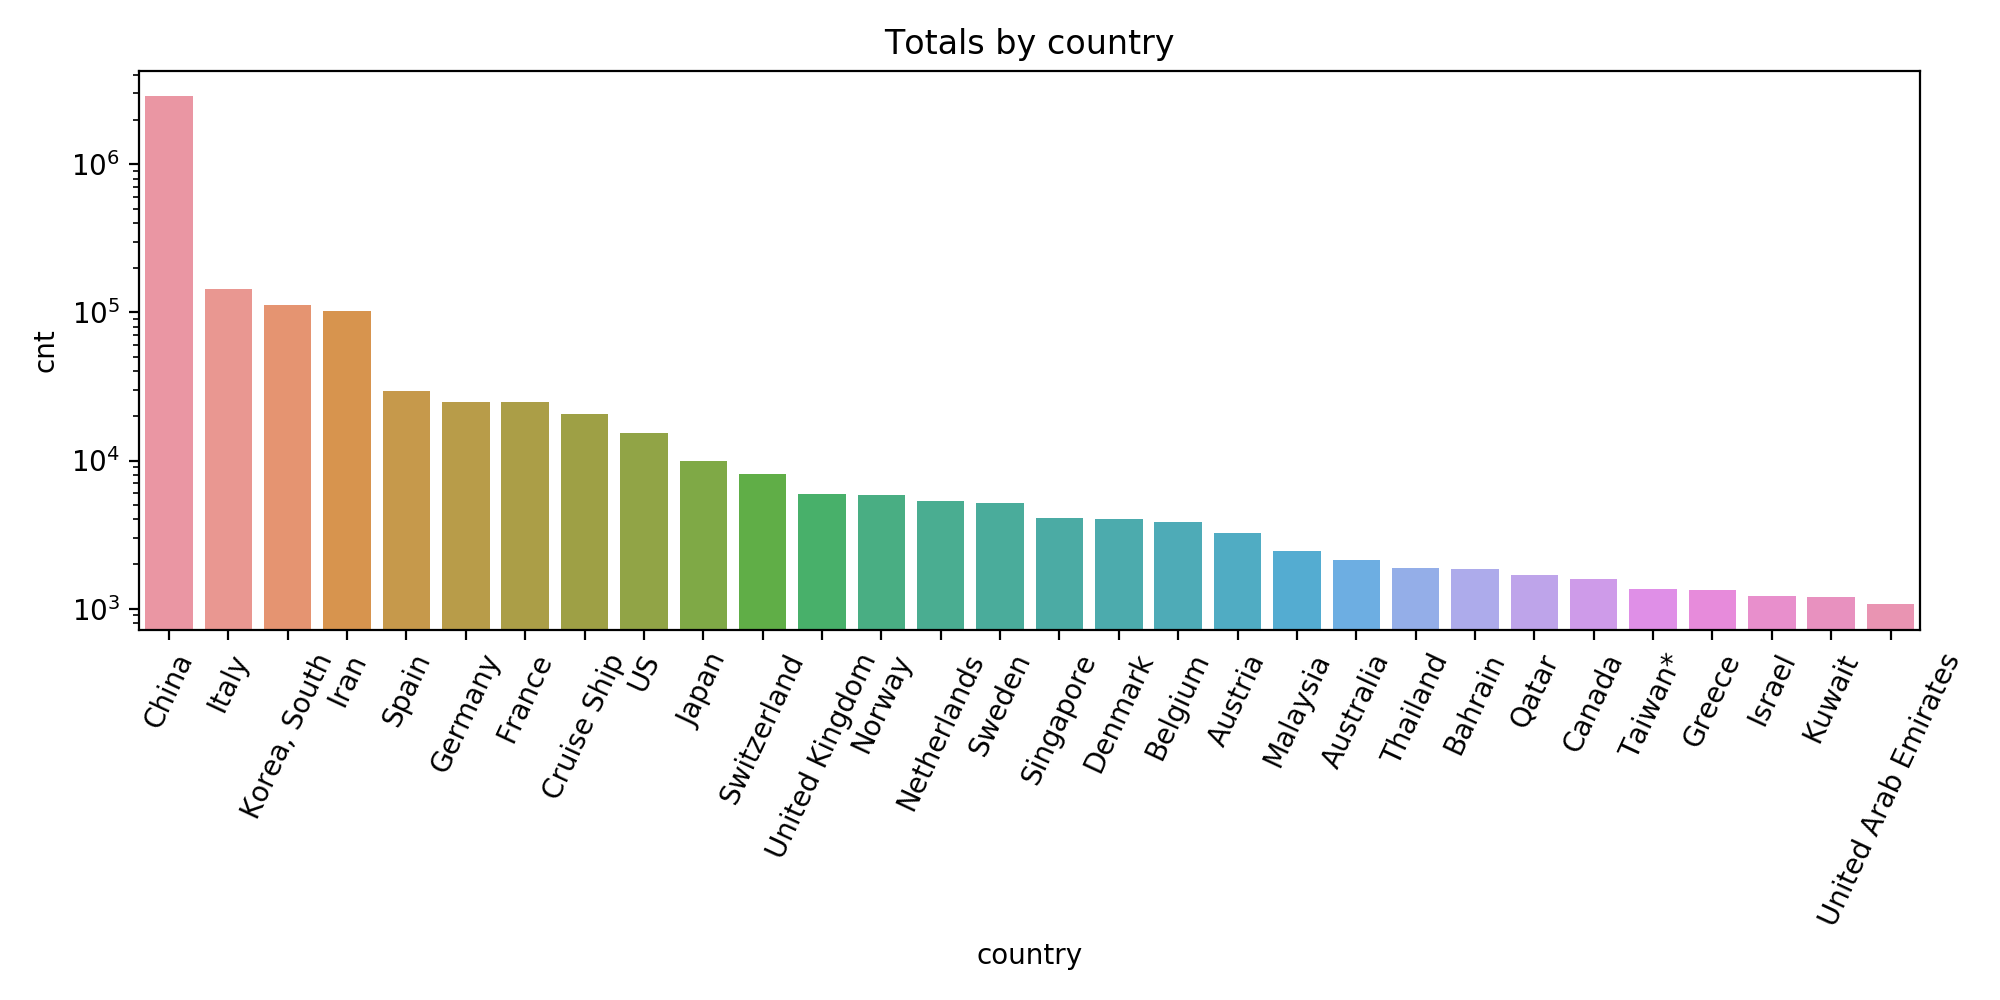

In [36]:
import seaborn as sns

figure(figsize=(10,5))
cnt_by_country = df.groupby('country').cnt.sum().sort_values(ascending=False)
df_wtotal = (
    df.merge(cnt_by_country.reset_index().rename(columns=dict(cnt='total')), on='country')
      .sort_values('total', ascending=False)
)
sns.barplot(
    data=df_wtotal[df_wtotal.country.isin(cnt_by_country[:30].index)], 
    x='country', 
    y='cnt', 
    estimator=np.sum,
    ci=None
)
plt.xticks(rotation=65)
gca().set_yscale('log')
title('Totals by country')
plt.tight_layout()

## Total number of reported cases per country

In [66]:
to_plot = df.groupby('country').cnt.sum().sort_values(ascending=False)[:50]
m, M = np.log10(to_plot.min()), np.log10(to_plot.max())
m, M

(2.568201724066995, 6.459607922793618)

In [127]:
def get_current_rate(df, window=7):
    dates = sorted(df.date.unique())
    current_df = df[df.date >= dates[-window]]
    res = {
        c: get_rate(current_df[current_df.country==c], rolling_win=5, min_cnt=10).mean() 
        for c in current_df.country.unique()
    }
    return {k: v for k, v in res.items() if not np.isnan(v)}

In [136]:
from IPython.display import display, Markdown
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

to_plot = df.groupby('country').cnt.sum().sort_values(ascending=False)[:50]
to_plot_rate = get_current_rate(df)
m = min(to_plot_rate.values())
M = max(to_plot_rate.values())

for country, cnt in to_plot.items():
    c_df = (
        df[df.country == country]
          .groupby('date')
          .cnt.sum()
          .reset_index()
          .sort_values('date')
    )
    c_df = c_df[c_df.cnt > 0]

    lum = int((to_plot_rate[country] - m) / (M - m) * 100)
    
    fig.add_trace(
        go.Scatter(
            x=c_df.date,
            y=c_df.cnt,
            name=country,
            line=dict(color=f'hsla(10, {lum}%, 50%, 0.5)'),
            opacity=0.8
        )
    )

fig.update_layout(yaxis_type="log")

display(Markdown("""
## Confirmed cases evolution by country
The lines that are most red correspond to countries that have the most rate of growth of COVID-19
"""
))
fig.show()


## Confirmed cases evolution by country
The lines that are most red correspond to countries that have the most rate of growth of COVID-19


## Rates of most affected countries

In [134]:
fig = go.Figure()

T = 1500

for country in df.country.unique():
    if cnt_by_country[country] < T: continue
    rate = get_rate(df[df.country == country])
    line = dict(width=8) if country == 'Mainland China' else None
    plot_rate(fig, rate, country, opacity=0.8, line=line)

rate = get_rate(df[df.country.isin([c for c, cnt in cnt_by_country.items() if cnt < T])])
plot_rate(fig, rate, f'Countries with less than {T}', dict(width=8))

rate = get_rate(df[df.country.isin([c for c, cnt in cnt_by_country.items() if cnt >= T and c != 'Mainland China'])])
plot_rate(fig, rate, f'Countries with more than {T}', dict(width=8))

fig.show()